# SARSA

SARSA stands for "state action reward state action", it gets this name because the agent updates its $Q$ function every time it takes an action, the idea is that the agent in state $s_t$, takes an action $a_t$ collects a reward $R_t$, observes its new state $s_{t+1}$, and decides what action he will take in this new state $a_{t+1}$; then it uses this information to updates $Q(s_t, a_t)$ by:



$$ Q(s_t, a_t) \leftarrow Q(s_{t}, a_{t}) + \alpha(R_t + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_{t}, a_{t}))$$



This a basic bootstrapping technique, $R_t + \gamma*Q(s_{t+1}, a_{t+1})$ is just an estimate for the state value action, based on what was observed, and what we already know for the next state-action. Which means $\alpha(R_t + \gamma*Q(s_{t+1}, a_{t+1}) - Q(s_{t}, a_{t}))$ is a $\alpha$-size step on the direction of this estimate.



After updating the $Q$ function, we will update our policy by making it $\epsilon$-greedy over $Q$, take the action we already decided on and repeat the process.



That is really all there is to it. This is much simpler to implement than Monte Carlo, so I won't go through the details in the notebook, you can directly check the details on the code base, it should be pretty easy to understand.

In [1]:
import sys

sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt
import itertools
import time

from exploring_agents import SarsaAgent
from exploring_agents.training import run_episode, train_agent
from grid_world.action import Action
from grid_world.grid_world import GridWorld
from grid_world.visualization.format_objects import (
    get_policy_rec_str,
    get_policy_eval_str,
    get_world_str,
)
from utils.returns import returns_from_reward
from utils.policy import get_policy_rec, get_random_policy, sample_action
from notebooks.utils.experimentation import (
    get_exp_results,
    get_results,
    moving_average,
    get_summary_df,
)
from exploring_agents.commons.dacaying_functions import get_linear_decay, get_exp_decay
from notebooks.utils.worlds import (
    small_world_01,
    small_world_02,
    small_world_03,
    large_world_01,
)
from notebooks.utils.basics import basic_actions, basic_reward

np.random.seed(50)

## Small World

We will start by exploring results in a small world. This example is meant to be a little chalenging, as there is a longer path that stays away from the traps, and a shorter one which is much more "dangerous"(like the cliff walking problem).

In [2]:
print(get_world_str(small_world_03))

6                ✘ 

5 ☠  ☠     █     █ 

4          █       

3    ☠  ☠  █  █    

2                  

1    █  █  █  █    

0 ⚐                

  0  1  2  3  4  5 


## Hyperparameters

Lets analyze how SARSA responds to changes in hyperparameters. We will focus in the learning rate $\alpha$ and the exploration rate $\epsilon$. We will consider the online performance of the alforithm as our objective, in the sense of maximizing the average rewards the agent gets. This target is a natural target for SARSA, since it's an on-policy learning algorithm. We will also try to understand what is the final police the agent is learning, and how good it is.

We will start by considering the average results of training rounds consisting of 200 episodes, which are usually enough for the agent to find a good(but not necessarily optimal) police. We will also look at the performance on the final 10 episodes, since they should indicate how well the agent would perform if it needed to continue doing this task. 

Our goal is not to explore these values in great depth, but rather just to get a good idea of what should be good ranges for our problem, and how they influence the agent performance. It is also not clear how this parameters performance may change from world to world, but this should give us a general idea.

In [3]:
training_rounds = 100
episodes = 200


base_arguments = {"reward_function": basic_reward, "actions": basic_actions}
arguments = {"alpha": [0.1, 0.3, 0.7, 1], "epsilon": [0.0003, 0.001, 0.003, 0.01, 0.03]}

results = get_exp_results(
    SarsaAgent, small_world_03, base_arguments, arguments, episodes, training_rounds
)

results_df = get_summary_df(results)
display(
    results_df.round(
        {
            "average_round_reward": 2,
            "std_round_reward": 2,
            "average_reward_final_10": 2,
            "std_reward_final_10": 2,
        }
    )
)

,alpha,epsilon,average_round_reward,std_round_reward,average_reward_final_10,std_reward_final_10,shortest_run
15,1.0,0.0003,-5793.58,126.38,-11.54,4.59,12
16,1.0,0.0010,-5892.42,214.34,-11.86,4.25,12
10,0.7,0.0003,-6000.15,138.78,-11.16,0.64,12
11,0.7,0.0010,-6097.54,202.46,-11.88,4.30,12
17,1.0,0.0030,-6157.48,262.18,-13.23,8.41,12
12,0.7,0.0030,-6280.98,213.26,-12.84,5.44,12
18,1.0,0.0100,-6539.47,262.42,-14.67,9.49,12
13,0.7,0.0100,-6604.00,268.17,-13.31,1.18,12
14,0.7,0.0300,-6965.26,407.57,-14.88,9.52,12
5,0.3,0.0003,-7037.61,46.12,-11.13,3.49,12


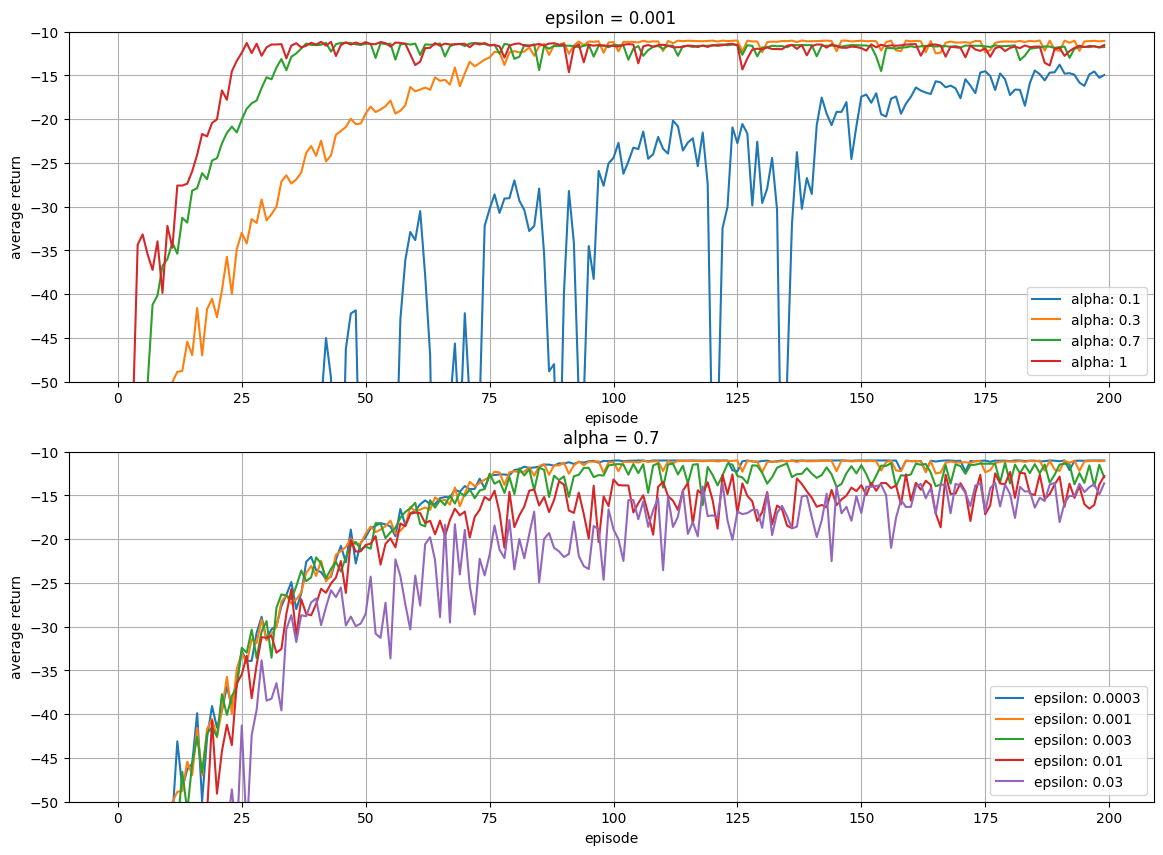

In [4]:
fig, axs = plt.subplots(2, figsize=(14, 10))

for (params, values) in results:
    if params["epsilon"] == 0.001:
        axs[0].plot(
            np.mean(np.array(values[0]), axis=0), label=f'alpha: {params["alpha"]}'
        )

axs[0].set(xlabel="episode", ylabel="average return", ylim=[-50, -10])
axs[0].grid()
axs[0].legend(loc="lower right")
axs[0].set_title("epsilon = 0.001")

for (params, values) in results:
    if params["alpha"] == 0.3:
        axs[1].plot(
            np.mean(np.array(values[0]), axis=0), label=f'epsilon: {params["epsilon"]}'
        )

axs[1].set(xlabel="episode", ylabel="average return", ylim=[-50, -10])
axs[1].grid()
axs[1].legend(loc="lower right")
axs[1].set_title("alpha = 0.7")


plt.show()

in general it seems to be the case that high values of $\alpha$ lead to faster learning, while small values of $\epsilon$ are related to a better performance on final rounds. This makes some sense, but may not be all there ir to it. 

First we can notice that some agents seems to be taking the short path, while others take the longer one.

In [5]:
agent = SarsaAgent(
    reward_function=basic_reward,
    actions=basic_actions,
    gamma=1,
    alpha=1,
    epsilon=0.0003,
)

episode_lengths, episode_returns = train_agent(
    agent=agent, world=small_world_03, episodes=200
)
pi_r = get_policy_rec(agent.policy, small_world_03, agent.actions)
print(get_policy_rec_str(pi_r, small_world_03))

 →  ↑  →  →  →  ✘ 

 ☠  ☠  ↑  █  ↑  █ 

 →  →  ↑  █  ↑  ← 

 ↑  ☠  ☠  █  █  ↑ 

 ↑  →  →  →  ↑  ↑ 

 ↑  █  █  █  █  ↑ 

 ↑  →  →  →  →  ↑ 




$\epsilon = 0.0003$: with a low exploration policy the agent prefers the riskier path.

In [6]:
agent = SarsaAgent(
    reward_function=basic_reward,
    actions=basic_actions,
    gamma=1,
    alpha=1,
    epsilon=0.01,
)

episode_lengths, episode_returns = train_agent(
    agent=agent, world=small_world_03, episodes=200
)
pi_r = get_policy_rec(agent.policy, small_world_03, agent.actions)
print(get_policy_rec_str(pi_r, small_world_03))

 →  ↑  →  →  →  ✘ 

 ☠  ☠  ↑  █  ↑  █ 

 →  →  ↑  █  ↑  ← 

 ↑  ☠  ☠  █  █  ↑ 

 ↑  ←  →  →  →  ↑ 

 ↑  █  █  █  █  ↑ 

 →  →  →  →  →  ↑ 




$\epsilon = 0.01$: on the other hand a high exploration rate leads to the long and safe path. 

This makes sense since with a higher exploration rate the agent is more likely to hit one of the traps in the short path. This is an expected behaviour for an on policy agent.

## Long Runs

Lets take a look on how some agents behave in a long run. For this purpose we will look at a single run, and plot some moving averages(to smooth out the curves, so we can actually see something) of episodes lengths and returns to see what is going on.

In [7]:
base_arguments = {"reward_function": basic_reward, "actions": basic_actions}
arguments = {"alpha": [0.1, 0.7], "epsilon": [0.001, 0.03]}

long_run_results = get_exp_results(
    SarsaAgent, small_world_03, base_arguments, arguments, 5000, 1
)

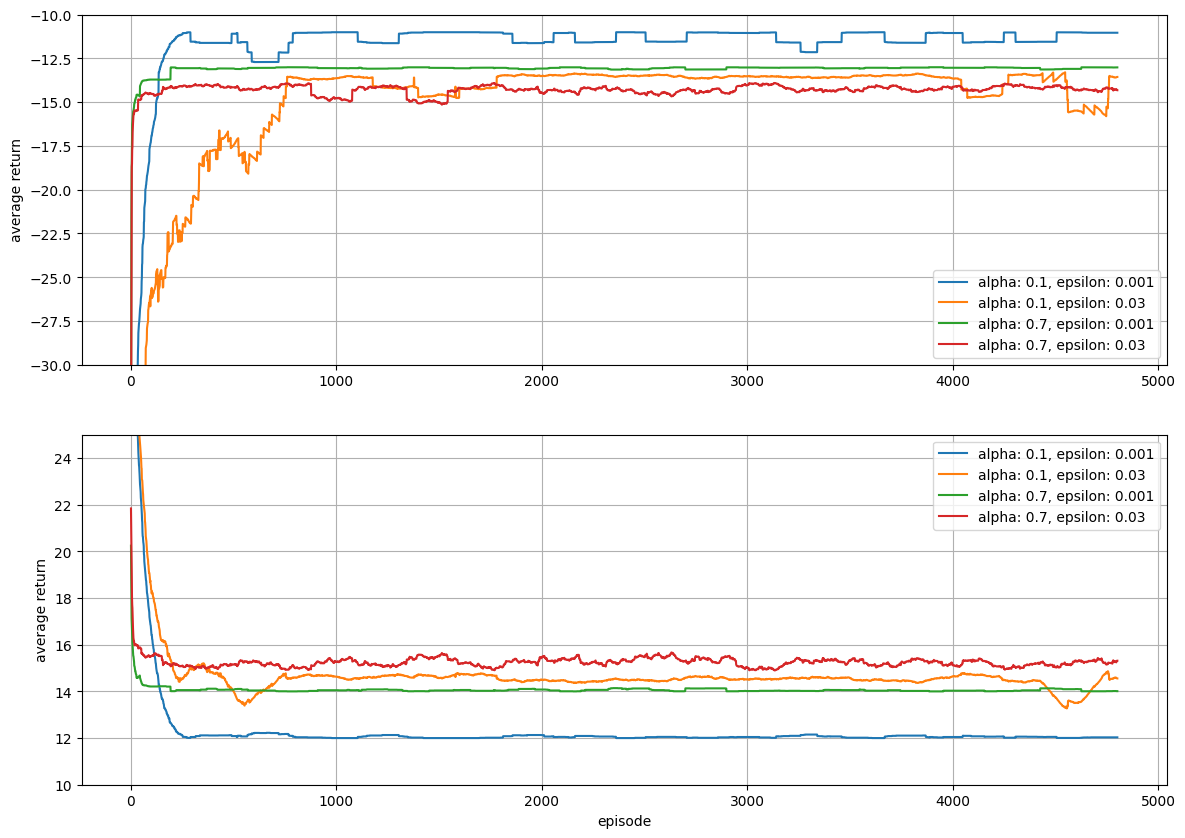

In [8]:
fig, axs = plt.subplots(2, figsize=(14, 10))

for (params, values) in long_run_results:
    v = np.mean(np.array(values[0]), axis=0)
    axs[0].plot(
        moving_average(v, 200),
        label=f'alpha: {params["alpha"]}, epsilon: {params["epsilon"]}',
    )

axs[0].set(ylabel="average return", ylim=[-30, -10])
axs[0].grid()
axs[0].legend(loc="lower right")

for (params, values) in long_run_results:
    v = np.mean(np.array(values[1]), axis=0)
    axs[1].plot(
        moving_average(v, 200),
        label=f'alpha: {params["alpha"]}, epsilon: {params["epsilon"]}',
    )

axs[1].set(xlabel="episode", ylabel="average return", ylim=[10, 25])
axs[1].grid()
axs[1].legend(loc="upper right")


plt.show()

Looking at these plots we can see that only one of the agents stayed on the short path, while others changed behaviour in all sorts of manner during the long run.

According to "Reinforcement Learning:An Introduction" we have

"According to Satinder Singh (personal communication), Sarsa converges with probability 1 to an optimal policy and action-value function as
long as all state–action pairs are visited an infinite number of times and the policy converges in the limit to the greedy policy (which can be arranged, for example, with ε-greedy policies by setting ε = 1/t) ..."

So lets see what happens when we set our exploration to decay over time

## Parameters decay

There are many ways to decay our parameters. Lets plot some options to inform our decision. Even though theoretically they all work, the performance on practice is very different.
We will limit the decay at 0.0001, as this should be enough to ensure that the greedy policy is optmal, while avoiding our parameters to literaly became 0 due to computational approximations.

In [9]:
linear_decay = get_linear_decay(decay=1e-6, min_value=1e-4)
exp_decay = get_exp_decay(decay_lambda=1e-3, min_value=1e-4)
exp_decay_lamb_01 = get_exp_decay(decay_lambda=1e-4, min_value=1e-4)
exp_decay_lamb_005 = get_exp_decay(decay_lambda=1e-5, min_value=1e-4)

x_range = range(int(1e6))

x = 0.3
lin_y = [x := (linear_decay(x)) for _ in x_range]
x = 0.3
exp_y0 = [x := (exp_decay(x)) for _ in x_range]
x = 0.3
exp_y1 = [x := (exp_decay_lamb_01(x)) for _ in x_range]
x = 0.3
exp_y2 = [x := (exp_decay_lamb_005(x)) for _ in x_range]

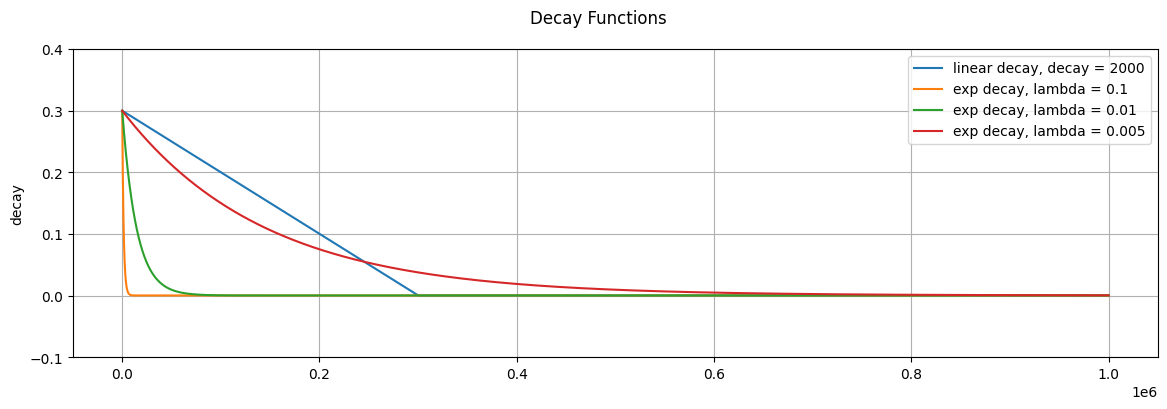

In [10]:
fig, ax = plt.subplots(figsize=(14, 4))
fig.suptitle("Decay Functions")

ax.plot(x_range, lin_y, label="linear decay, decay = 2000")
ax.plot(x_range, exp_y0, label="exp decay, lambda = 0.1")
ax.plot(x_range, exp_y1, label="exp decay, lambda = 0.01")
ax.plot(x_range, exp_y2, label="exp decay, lambda = 0.005")

ax.set(ylabel="decay", ylim=[-0.1, 0.4])
ax.grid()
ax.legend(loc="upper right");

In [11]:
base_arguments = {
    "reward_function": basic_reward,
    "actions": basic_actions,
    "epsilon_decay": get_exp_decay(decay_lambda=1e-3, min_value=1e-4),
}
arguments = {"alpha": [0.1, 0.7], "epsilon": [0.01, 0.1]}

decay_results = get_exp_results(
    SarsaAgent, small_world_03, base_arguments, arguments, int(1e4), 1
)

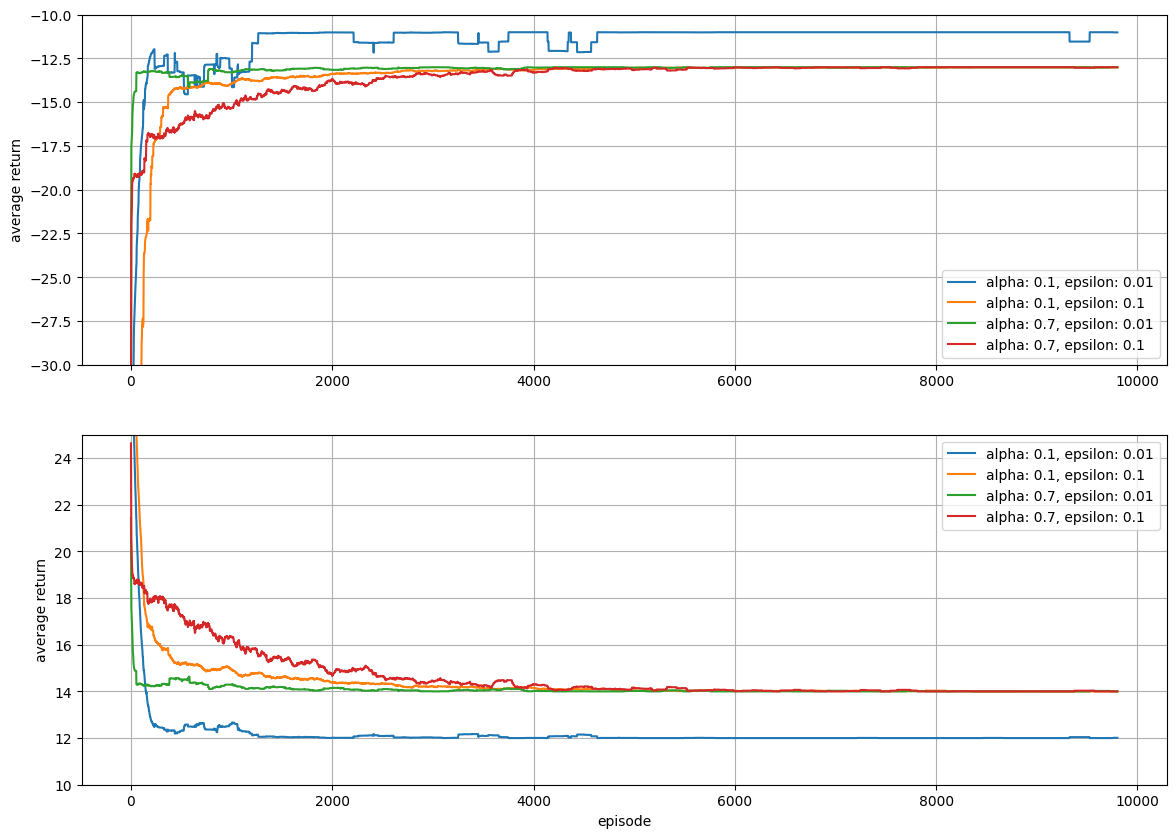

In [12]:
fig, axs = plt.subplots(2, figsize=(14, 10))

for (params, values) in decay_results:
    v = np.mean(np.array(values[0]), axis=0)
    axs[0].plot(
        moving_average(v, 200),
        label=f'alpha: {params["alpha"]}, epsilon: {params["epsilon"]}',
    )

axs[0].set(ylabel="average return", ylim=[-30, -10])
axs[0].grid()
axs[0].legend(loc="lower right")

for (params, values) in decay_results:
    v = np.mean(np.array(values[1]), axis=0)
    axs[1].plot(
        moving_average(v, 200),
        label=f'alpha: {params["alpha"]}, epsilon: {params["epsilon"]}',
    )

axs[1].set(xlabel="episode", ylabel="average return", ylim=[10, 25])
axs[1].grid()
axs[1].legend(loc="upper right")


plt.show()

The policies show a lot less variation in the chosen path. and when epsilon gets small enough they barely ever change.

However they don't seem to be converging to the greedy path. This obviously doesn't contradict the theory. It just makes it very clear that, once the agent has learned a path, in order to have it change its police to the greed one we need a low value for $\epsilon$, which in turn limits exploration and by make it hard for the agent to discover such a path.

Of course there a lot to parameters to play around here, and we could probably get better results by fine tunning then. But if we want to address this problem it is probably better to just use other algorithms.

It is also worth notting that in every case, the only agent that found and stayed on the greedy path was the one with low learning and exploration rates. On the other hand this was one of the worst performing agents on the first 200 rounds. Showing an important tradeoff. 

# Large World

In [13]:
print(get_world_str(large_world_01))

9    ☠     █             

8          █     █  █    

7                   █    

6    █  █  █     ✘  █    

5          █  █  █       

4    ☠     █     █     █ 

3 █  ☠     █           █ 

2                █     █ 

1    █  █  █     █     █ 

0 ⚐                    █ 

  0  1  2  3  4  5  6  7 


In [14]:
training_rounds = 100
episodes = 500

base_arguments = {"reward_function": basic_reward, "actions": basic_actions}
arguments = {"alpha": [0.3, 0.7], "epsilon": [0.001, 0.01, 0.1]}

results = get_exp_results(
    SarsaAgent, large_world_01, base_arguments, arguments, episodes, training_rounds
)

results_df = get_summary_df(results)
display(
    results_df.round(
        {
            "average_reward": 2,
            "std_reward": 2,
            "average_reward_final_10": 2,
            "std_reward_final_10": 2,
        }
    )
)

,alpha,epsilon,average_round_reward,std_round_reward,average_reward_final_10,std_reward_final_10,shortest_run
3,0.7,0.001,-14801.24,1179.288100,-20.36,7.30,18
4,0.7,0.010,-17312.95,500.983440,-23.73,1.94,18
0,0.3,0.001,-17346.85,247.077614,-17.43,5.67,18
1,0.3,0.010,-19701.57,807.162465,-22.52,12.59,18
5,0.7,0.100,-22474.28,429.248252,-32.27,13.16,18
2,0.3,0.100,-25348.65,437.627247,-27.73,11.34,18


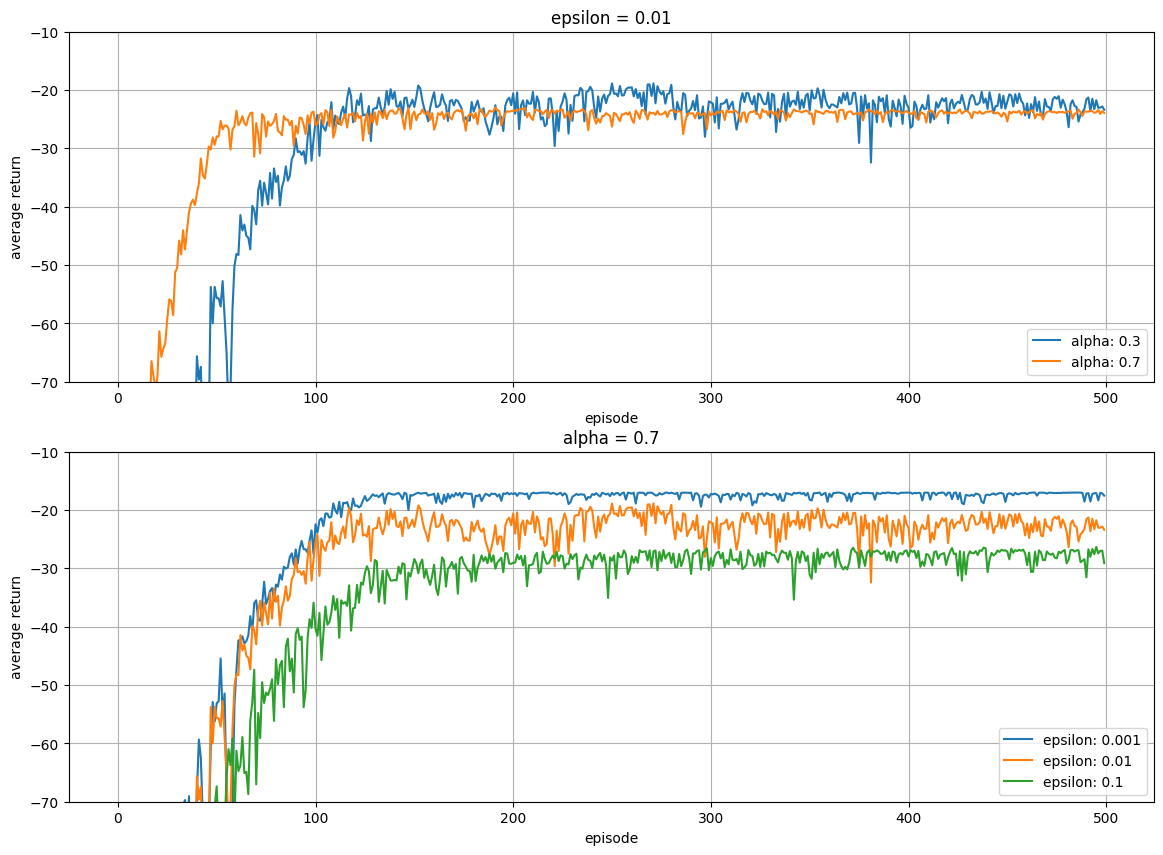

In [15]:
fig, axs = plt.subplots(2, figsize=(14, 10))

for (params, values) in results:
    if params["epsilon"] == 0.01:
        axs[0].plot(
            np.mean(np.array(values[0]), axis=0), label=f'alpha: {params["alpha"]}'
        )

axs[0].set(xlabel="episode", ylabel="average return", ylim=[-70, -10])
axs[0].grid()
axs[0].legend(loc="lower right")
axs[0].set_title("epsilon = 0.01")

for (params, values) in results:
    if params["alpha"] == 0.3:
        axs[1].plot(
            np.mean(np.array(values[0]), axis=0), label=f'epsilon: {params["epsilon"]}'
        )

axs[1].set(xlabel="episode", ylabel="average return", ylim=[-70, -10])
axs[1].grid()
axs[1].legend(loc="lower right")
axs[1].set_title("alpha = 0.7")


plt.show()

As expected, it appears the agent changes behaviour depending on our exploration rate. With lower values leading to greedier policies.

And although high values of $\alpha$ lead to better rewards overall, the police learned may not be as good as the one for intermediate values, as the results of final episdos indicate. 

Lets check this out in an example.

In [16]:
agent = SarsaAgent(
    reward_function=basic_reward,
    actions=basic_actions,
    gamma=1,
    alpha=0.3,
    epsilon=0.01,
)

episode_lengths, episode_returns = train_agent(agent, large_world_01, episodes=2000)
pi_r = get_policy_rec(agent.policy, large_world_01, agent.actions)
print(get_policy_rec_str(pi_r, large_world_01))

 ↑  ☠  ↑  █  ↓  ←  ←  ← 

 →  →  ↓  █  ↓  █  █  ↑ 

 →  →  →  →  ↓  ↓  █  ↑ 

 ↑  █  █  █  →  ✘  █  ↑ 

 ↑  ←  ←  █  █  █  →  ↑ 

 ↑  ☠  ↑  █  ↓  █  ↑  █ 

 █  ☠  ↑  █  →  →  ↑  █ 

 ←  →  →  →  ↑  █  ↑  █ 

 →  █  █  █  ↑  █  ↑  █ 

 →  →  →  →  ↑  →  ↑  █ 




In [17]:
agent = SarsaAgent(
    reward_function=basic_reward,
    actions=basic_actions,
    gamma=1,
    alpha=0.3,
    epsilon=0.001,
)

episode_lengths, episode_returns = train_agent(agent, large_world_01, episodes=2000)
pi_r = get_policy_rec(agent.policy, large_world_01, agent.actions)
print(get_policy_rec_str(pi_r, large_world_01))

 ↑  ☠  ↑  █  ↓  ←  ←  ← 

 ↓  →  ↑  █  ↓  █  █  ↑ 

 →  →  →  →  →  ↓  █  ↑ 

 ↑  █  █  █  →  ✘  █  ↑ 

 ↑  ←  ←  █  █  █  →  ↑ 

 ←  ☠  ↑  █  ←  █  ↑  █ 

 █  ☠  ↑  █  →  →  ↑  █ 

 →  →  ↑  ↑  ↑  █  ↑  █ 

 ↑  █  █  █  ↑  █  ↑  █ 

 ↑  →  →  →  ↑  →  ↓  █ 




As expected the agent with high exploration prefers the safe path, while the other preferred the shorter one.

In [18]:
base_arguments = {
    "reward_function": basic_reward,
    "actions": basic_actions,
    "epsilon_decay": get_exp_decay(decay_lambda=1e-3, min_value=1e-4),
}
arguments = {"alpha": [0.1, 0.7], "epsilon": [0.01, 0.1]}

decay_results = get_exp_results(
    SarsaAgent, large_world_01, base_arguments, arguments, int(1e4), 1
)

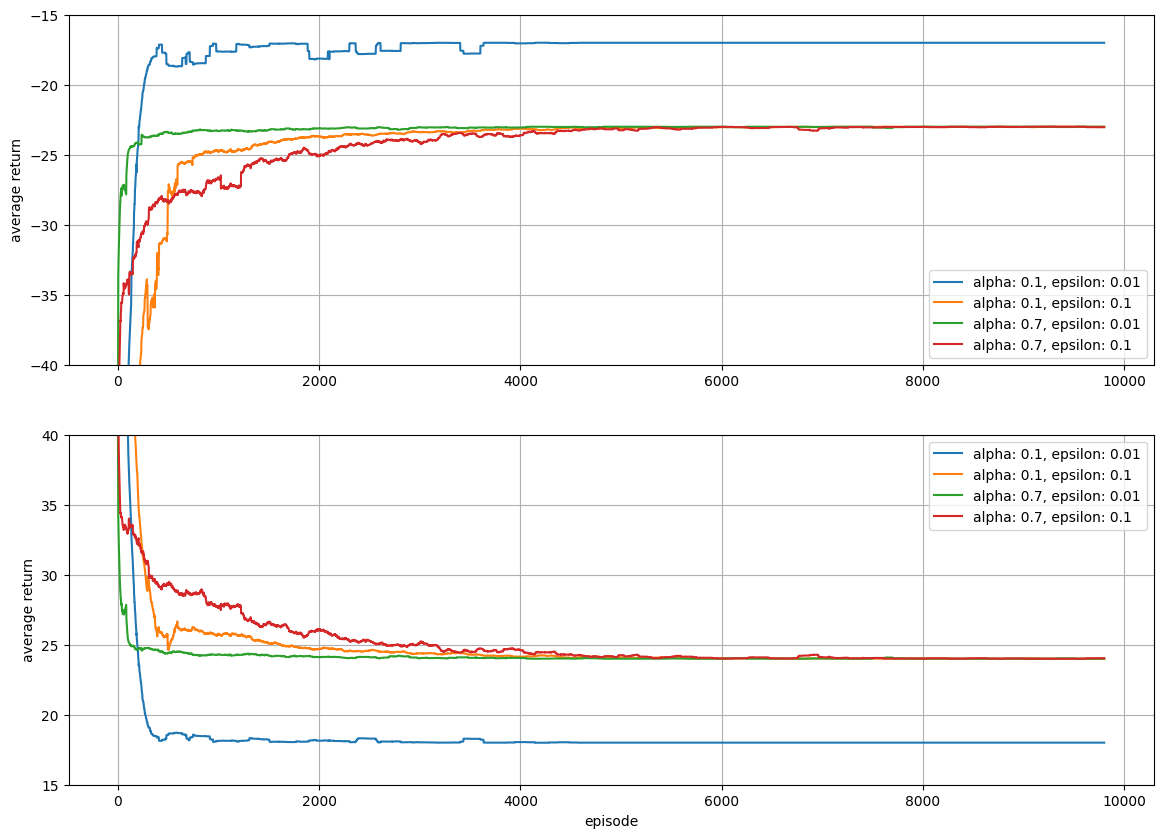

In [19]:
fig, axs = plt.subplots(2, figsize=(14, 10))

for (params, values) in decay_results:
    v = np.mean(np.array(values[0]), axis=0)
    axs[0].plot(
        moving_average(v, 200),
        label=f'alpha: {params["alpha"]}, epsilon: {params["epsilon"]}',
    )

axs[0].set(ylabel="average return", ylim=[-40, -15])
axs[0].grid()
axs[0].legend(loc="lower right")

for (params, values) in decay_results:
    v = np.mean(np.array(values[1]), axis=0)
    axs[1].plot(
        moving_average(v, 200),
        label=f'alpha: {params["alpha"]}, epsilon: {params["epsilon"]}',
    )

axs[1].set(xlabel="episode", ylabel="average return", ylim=[15, 40])
axs[1].grid()
axs[1].legend(loc="upper right")


plt.show()

This is very similar to the results on the medium world, where only one agent converged to the greedy police. And although decaying the police lead to stable policies, it didn't lead to the greedy one, showing how difficult it can be for this type agent to learn such policies.

## Conclusion

Although the agent is quite capable of solving the problem, it can be difficult to find the greedy policy using it.

The parameters have a significant impact, in particular:

* high values of $\alpha$ lead to fast learning, but behaviour can get erratic on long runs.
* low values of $\epsilon$ and $\alpha$ lead to slow learning, but were the best way to guarantee the agent got the greedy police.
* decaying the exploration rate lead to stable policies, but even with somewhat long runs they didn't converge to the greedy police. According to theory this would eventually happen, but it can certainly take a long time.